## Data Prep

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import interpolate
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
# Read CSV files
df_research = pd.read_csv('papers_with_models.csv')
df_released = pd.read_csv('Epoch Database - Notable Systems.csv')

# Process research dataframe
df_research['date'] = pd.to_datetime(df_research['publication date (first revision)'])
df_research['year'] = pd.to_datetime(df_research['date']).dt.year
df_research['param count'] = pd.to_numeric(df_research['param count'], errors='coerce')
df_research['mmlu_accuracy'] = pd.to_numeric(df_research['mmlu_accuracy'], errors='coerce')
df_research['hellaswag_accuracy'] = pd.to_numeric(df_research['hellaswag_accuracy'], errors='coerce')
df_research['arc_accuracy'] = pd.to_numeric(df_research['arc_accuracy'], errors='coerce')
df_research['Type'] = 'Models used in research'

# Process released dataframe
df_released['date'] = pd.to_datetime(df_released['Publication date'])
df_released['year'] = df_released['date'].dt.year
df_released['param count'] = pd.to_numeric(df_released['Parameters'], errors='coerce')
df_released['Type'] = 'Models released'

In [2]:
# Prep the dataset of research models
df_research = df_research.sort_values(['date', 'param count'])

# Create masks for rows with missing accuracies
mmlu_mask = df_research['mmlu_accuracy'].isna() | (df_research['mmlu_accuracy'] == 0)
hellaswag_mask = df_research['hellaswag_accuracy'].isna() | (df_research['hellaswag_accuracy'] == 0)
arc_mask = df_research['arc_accuracy'].isna() | (df_research['arc_accuracy'] == 0)

# Perform nearest neighbor interpolations for MMLU accuracy
f = interpolate.interp1d(df_research.loc[~mmlu_mask, 'param count'], 
                         df_research.loc[~mmlu_mask, 'mmlu_accuracy'], 
                         kind='nearest')
df_research.loc[mmlu_mask, 'mmlu_accuracy'] = f(df_research.loc[mmlu_mask, 'param count'])

In [3]:
# Prep the dataset of released models
df_released = df_released[(df_released['year'] >= 2019) & 
                            (df_released['year'] <= 2024)]


df_released = df_released.sort_values(by='date')
df_released = df_released[df_released['Domain'].str.contains('Language')]
df_released = df_released[df_released['Model accessibility'].str.contains('Open access', na=False)]

# Filter out rows with NaN in 'param_count'
df_released = df_released.dropna(subset=['param count'])

In [4]:
def get_max_list(df, metric='mmlu_accuracy'):
    """
    Get a list of rows with maximum scores for a given metric.
    
    This function iterates through the dataframe and keeps track of the rows
    with the highest score for the specified metric. If multiple rows have
    the same evaluation date, only the row with the highest score is kept.
    
    Args:
        df (pandas.DataFrame): The input dataframe.
        metric (str): The column name of the metric to maximize. Default is 'mmlu_accuracy'.
    
    Returns:
        list: A list of dataframe rows with the maximum scores.
    """
    max_score = 0
    max_score_list = []

    for i,x in df.iterrows():

        if x[metric] > max_score:
            max_score = x[metric]
            if len(max_score_list) == 0:
                max_score_list.append(x)
            else:
                if max_score_list[-1].evaluation_date == x.evaluation_date:
                    max_score_list[-1] = x
                else:
                    max_score_list.append(x)

    return max_score_list


## MMLU Plot

In [6]:
# Set up a list of open and closed models with highest MMLU scores

mmlu_df  = pd.read_csv('mmlu_data/mmlu_benchmark_results_clean_labeled.csv')

mmlu_df['evaluation_date'] = pd.to_datetime(mmlu_df['evaluation_date'])
mmlu_df['open_weights'] = mmlu_df['open_weights'].astype(bool)

# Select only the relevant columns
mmlu_df = mmlu_df[['rank', 'method_short', 'evaluation_date', 'mmlu_accuracy', 'open_weights']]

# Separate open and closed models, sort by evaluation date
open_mmlu_df = mmlu_df[mmlu_df.open_weights == True].sort_values(by='evaluation_date', ascending=True)
closed_mmlu_df = mmlu_df[mmlu_df.open_weights == False].sort_values(by='evaluation_date', ascending=True)

max_closed = get_max_list(closed_mmlu_df)
max_open = get_max_list(open_mmlu_df)

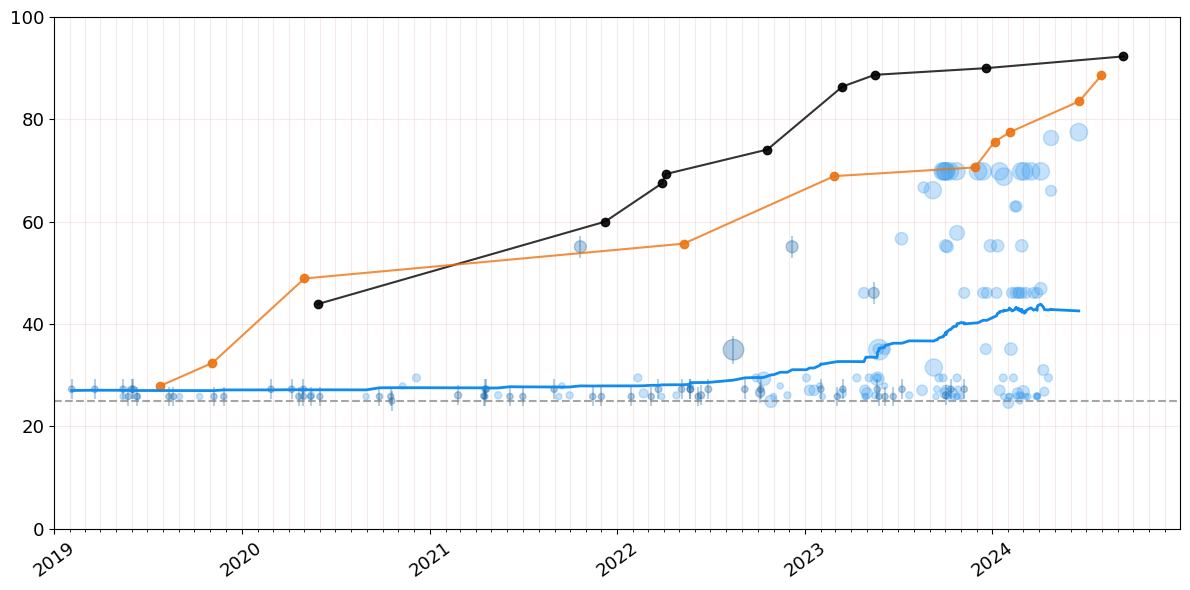

In [10]:
# from adjustText import adjust_text

# Set up the plot
plt.figure(figsize=(12, 6))
ax = plt.gca()

# Calculate the rolling average
window_size = 90
df_research['rolling_avg'] = df_research['mmlu_accuracy'].rolling(window=window_size, center=True, min_periods=1).mean()
# Plot the rolling average
plt.plot(df_research['date'], df_research['rolling_avg'], color="#118BEE", linewidth=2, label='90-day rolling average')

# Add horizontal dashed line for random baseline
plt.axhline(y=25, color='gray', linestyle='--', alpha=0.7, label='Random baseline (25%)')

# Function to scale parameter count to marker size with more pronounced differences
def scale_marker_size_20_220(param_count):
    # Convert to log scale
    log_param = np.log10(param_count)
    # Scale to 0-1 range
    normalized = (log_param - np.log10(df_research['param count'].min())) / (np.log10(df_research['param count'].max()) - np.log10(df_research['param count'].min()))
    # Apply power function to create more pronounced differences
    powered = np.power(normalized, 3)  # You can adjust this power (3) to increase or decrease the effect
    # Scale to 20-120 range
    scaled_size = 20 + powered * 200
    return scaled_size

def scale_marker_size_200_400(param_count):
    # Convert to log scale
    log_param = np.log10(param_count)
    # Scale to 0-1 range
    normalized = (log_param - np.log10(df_research['param count'].min())) / (np.log10(df_research['param count'].max()) - np.log10(df_research['param count'].min()))
    # Apply power function to create more pronounced differences
    powered = np.power(normalized, 3)  # You can adjust this power (3) to increase or decrease the effect
    # Scale to 20-120 range
    scaled_size = 200 + powered * 200
    return scaled_size

# Plot original data points with scaled marker size
plt.scatter(df_research.loc[~mmlu_mask, 'date'], 
            df_research.loc[~mmlu_mask, 'mmlu_accuracy'], 
            color="#41A2F1", alpha=0.3, 
            s=df_research.loc[~mmlu_mask, 'param count'].apply(scale_marker_size_20_220),
            label='Models with MMLU available')

# Plot interpolated data points with 'X' marker and scaled marker size
plt.scatter(df_research.loc[mmlu_mask, 'date'], 
            df_research.loc[mmlu_mask, 'mmlu_accuracy'], 
            color="#0C5FA3", alpha=0.3, 
            s=df_research.loc[mmlu_mask, 'param count'].apply(scale_marker_size_20_220),
            marker='o', label='Models with MMLU interpolated')
plt.scatter(df_research.loc[mmlu_mask, 'date'], 
            df_research.loc[mmlu_mask, 'mmlu_accuracy'], 
            color="#0C5FA3", alpha=0.3, 
            s=df_research.loc[mmlu_mask, 'param count'].apply(scale_marker_size_200_400),
            marker='|', label='Models with MMLU interpolated')


plt.plot([x.evaluation_date for x in max_closed], [x.mmlu_accuracy for x in max_closed], color='black', alpha=0.8, )
plt.scatter([x.evaluation_date for x in max_closed], [x.mmlu_accuracy for x in max_closed], 
            color='black', alpha=0.9, label='Highest scoring closed models') 

plt.plot([x.evaluation_date for x in max_open], [x.mmlu_accuracy for x in max_open], color='#EE7411', alpha=0.8)
plt.scatter([x.evaluation_date for x in max_open], [x.mmlu_accuracy for x in max_open], 
            color='#EE7411', alpha=0.9, label='Highest scoring open models')  

# # Create text annotations (unchanged)
# texts = []
# for point in max_closed:
#     texts.append(plt.text(point.evaluation_date, point.mmlu_accuracy, point.method_short,
#                         fontsize=9,
#                         bbox=dict(boxstyle="round,pad=0.3", fc=palette['bg_light_blue'], ec="gray", alpha=0.8)))
    
# for point in max_open:
#     texts.append(plt.text(point.evaluation_date, point.mmlu_accuracy, point.method_short,
#                         fontsize=9,
#                         bbox=dict(boxstyle="round,pad=0.3", fc=palette['bg_muted_brown'], ec="gray", alpha=0.8)))

# # Use adjust_text to prevent overlap (unchanged)
# adjust_text(texts, 
#             force_points=(0, 0),
#             force_text=(0.5, 1.2),
#             expand_points=(0, 0),
#             expand_text=(0.1, 0.5),
#             )

# # Set labels and title
# ax.set_title('MMLU Score Trends Comparison', fontsize=16)   
# ax.set_xlabel('Publication Date', fontsize=14)  
# ax.set_ylabel("MMLU Average (%)", fontsize=14)  

# Customize the x-axix
ax.set_xlim(pd.Timestamp('2019-01-01'), pd.Timestamp('2024-12-31'))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())

# Set font size for y-axis tick labels
ax.tick_params(axis='y', which='major', labelsize=13)
ax.tick_params(axis='y', which='minor', labelsize=13)  
# Set font size for y-axis tick labels and rotate them slightly
ax.tick_params(axis='x', which='major', labelsize=13, rotation=36)
ax.tick_params(axis='x', which='minor', labelsize=13, rotation=36)

# # Remove x-axis labels
# ax.set_xticklabels([])

# # Remove y-axis labels
# ax.set_yticklabels([])

# Set y-axis limits to 0-100
ax.set_ylim(0, 100)

# Customize the grid (unchanged)
plt.grid(True, which="both", ls="-", alpha=0.1, color='brown')

# Add legend
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot with tight layout
plt.tight_layout()
# Save the current figure as a SVG
plt.savefig('scatterplot.svg', format='svg', dpi=300, bbox_inches='tight')
plt.show()


## Box Plots

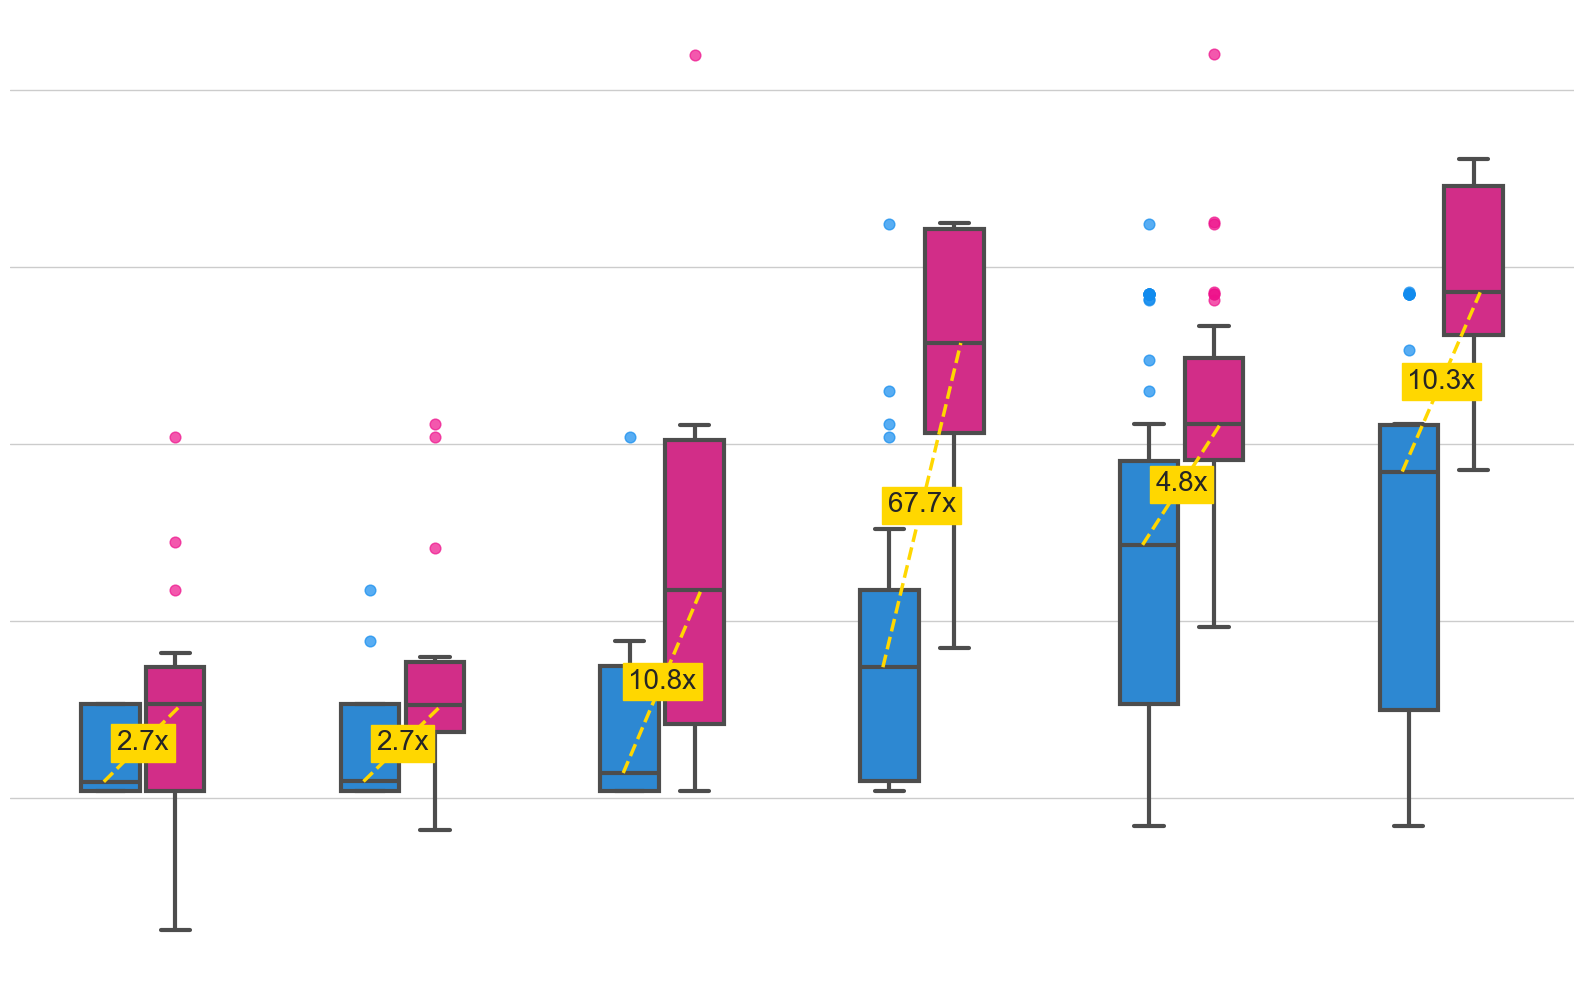

In [ ]:
# Set the theme before plotting
sns.set_theme(style="whitegrid")

plt.figure(figsize=(16, 10))
palette = {'Models used in research': '#118BEE', 'Models released': '#EE118B'}

# Define the order of 'Type' and 'year' for consistency
hue_order = ['Models used in research', 'Models released']
year_order = sorted(df_combined['year'].unique())

# Create boxplot without fliers and with specified order
ax = sns.boxplot(x='year', y='param count', hue='Type', data=df_combined, palette=palette, order=year_order, hue_order=hue_order, width=0.5, linewidth=3, showfliers=False, gap=0.1)

# Set the Y-axis to a logarithmic scale
ax.set_yscale('log')

# # Add titles and labels
# ax.set_title('Distribution of Model Sizes by Year', fontsize=24, fontweight='bold', pad=20)
# ax.set_xlabel('Year', fontsize=18, fontweight='bold', labelpad=15)
# ax.set_ylabel('Model Size (Number of Parameters)', fontsize=18, fontweight='bold', labelpad=15)

# Customize tick labels
# ax.tick_params(axis='both', which='major', labelsize=14)

# Remove all spines
for spine in ax.spines.values():
    spine.set_visible(False)

# Hide all axis labels
ax.set_xticklabels([])
ax.set_yticklabels([])

# Remove x and y labels
ax.set_xlabel('')
ax.set_ylabel('')

# Calculate and plot median values with connecting lines
for i, year in enumerate(year_order):
    medians = [df_combined[(df_combined['year'] == year) & (df_combined['Type'] == t)]['param count'].median() for t in ['Models used in research', 'Models released']]
    
    if not any(np.isnan(medians)):
        x1, x2 = i - 0.15, i + 0.15
        plt.plot([x1, x2], medians, color='gold', linestyle='--', linewidth=2.5, zorder=5)
        gap_ratio = max(medians) / min(medians)
        plt.text(i, np.sqrt(medians[0] * medians[1]), f'{gap_ratio:.1f}x',
                 ha='center', va='center',
                 bbox=dict(facecolor='gold', edgecolor='gold', alpha=1),
                 fontsize=20, zorder=20)

# Prepare outlier data using the IQR method
def is_outlier(s):
    q1, q3 = np.percentile(s, [25, 75])
    iqr = q3 - q1
    return (s < q1 - 1.5 * iqr) | (s > q3 + 1.5 * iqr)

outlier_data = df_combined.groupby(['year', 'Type']).apply(lambda x: x[is_outlier(x['param count'])]).reset_index(drop=True)

# Create a mapping from (year, Type) to x positions
# First, get the number of hue levels
n_hues = len(hue_order)
# Calculate the width of each box
box_width = 0.5
# Total dodge range
dodge_range = box_width / n_hues

# Create a dictionary to map (year, Type) to specific x positions
x_offsets = {t: (i - 0.5) * dodge_range for i, t in enumerate(hue_order)}

# Plot outliers manually using plt.scatter for precise alignment
for _, row in outlier_data.iterrows():
    # Check if the year is in our ordered list
    year_index = year_order.index(row['year']) if row['year'] in year_order else None
    if year_index is not None:
        # Calculate x position and plot the outlier
        x_pos = year_index + x_offsets.get(row['Type'], 0)
        plt.scatter(
            x_pos,
            row['param count'],
            color=palette.get(row['Type']),
            linewidth=1, alpha=0.7, s=60, zorder=15 
        )

ax.legend(title='Model Type', title_fontsize='16', fontsize='14', loc='upper left', frameon=True)
# Remove the legend
ax.get_legend().remove()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()
# Save the figure as SVG
plt.savefig('boxplot.svg', format='svg', dpi=300, bbox_inches='tight')

plt.show()

